# ACM Imbalanced Learning - Sampling Methods

This notebook contains a selection of various sampling methods used to modify an imbalanced dataset. These include undersampling and oversampling techniques. To simplify the visualization of the sampling, a small generated dataset it used.

In [144]:
# Import useful libraries used in the notebook
import time
import numpy as np
import matplotlib.pyplot as plt

# Show plots inline 
%matplotlib inline

from sklearn.datasets import make_classification

from pylab import rcParams

# Auto-reload external modules
%load_ext autoreload
%autoreload 2

plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=.95)
rcParams['figure.figsize'] = (10.0, 5.0)

def comp_scatter(x_left, y_left, title_left, x_right=None, y_right=None, title_right=None):
    '''
    Utility function to create comparison scatter plots. 
    '''
    # Plot left-hand scatterplot
    plt1 = plt.subplot(121)
    plt.title(title_left, fontsize='large')
    plt1.scatter(x_left[:, 0], x_left[:, 1], s=500, c=(1-y_left), 
                 edgecolors='black', cmap=plt.cm.bone, alpha=0.8)
    
    if (title_right == None):
        return 
    
    # Plot right hand scatterplot
    plt.subplot(122, sharex=plt1, sharey=plt1)
    plt.title(title_right, fontsize='large')
    plt.scatter(x_right[:, 0], x_right[:, 1], s=500, c=(1-y_right), 
                edgecolors='black', cmap=plt.cm.bone, alpha=0.8)    
    return 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate the dataset for use in the sampling code below.

To demonstrate the sampling methods, we'll generate a small dataset using scikit-learn's ```make_classification``` function we imported earlier. This has many parameters to control the generated data, the main ones we're using here are:

* Generate 100 samples - ```n_samples = 100```
* Use imbalance of 90:10 - ```weights=[0.9, 0.1]```
* Give repeatable data - ```random_state=23```


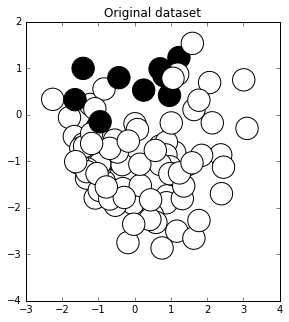

In [139]:
plt1 = plt.subplot(121)
plt.title("Original dataset", fontsize='large')
x, y = make_classification(n_samples=100, n_features=2, 
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2, weights=[0.9, 0.1],
                           random_state=23)
comp_scatter(x, y, 'Original dataset')

# Random Oversampling

In Random Oversampling, minority classes are duplicated and added to the dataset at random (without replacement). This can lead to overfitting due to the many duplicated minority cases which don't add any new information to the model.

# Random Undersampling

Random undersampling is the opposite of random oversampling. Instead of adding more minority examples, majority examples are removed to correct the balance.


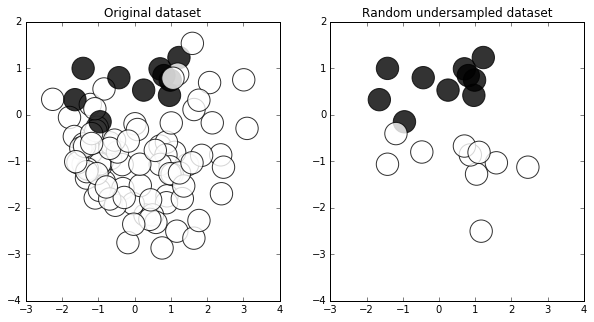

In [147]:
# Create a random sample with balanced examples
x_min = x[y == 1]
x_maj = x[y == 0]
num_min = x_min.shape[0]
num_maj = x_maj.shape[0]
x_maj_idx = np.random.randint(num_maj, size=num_min)
x_maj_undersamp = x_maj[x_maj_idx]

# Combine minority and balanced majority examples
x_undersamp = np.vstack((x_min, x_maj_undersamp))
y_undersamp = np.vstack(np.array(([1] * num_min) + ([0] * num_min)))

comp_scatter(x, y, 'Original dataset', 
             x_undersamp, y_undersamp, 'Random undersampled dataset')

In [ ]:

# plt.figure(figsize=(1, 2))
plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=.95)
rcParams['figure.figsize'] = (10.0, 5.0)


plt1 = plt.subplot(121)
plt.title("Original dataset", fontsize='large')
x, y = make_classification(n_samples=100, n_features=2, 
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,  weights=[0.9, 0.1]
                           , random_state=23)
# 12 looks good
# 23
# 33

plt1.scatter(x[:, 0], x[:, 1], s=500, c=(1-y), edgecolors='black', cmap=plt.cm.bone)

# plt.xlim(-4,4)
# plt.ylim(-4,4)
plt.subplot(122, sharex=plt1, sharey=plt1)
plt.title("Modified dataset", fontsize='large')
# plt.scatter(x[:, 0], x[:, 1], marker='o', c=y)





In [ ]:
comp_sca